In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from unidecode import unidecode

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram

from matplotlib import rcParams
from matplotlib.pyplot import subplots, figure, show, savefig
from matplotlib.gridspec import GridSpec
from matplotlib.patheffects import withStroke


path_data = '/Users/dariozappala/Library/CloudStorage/Dropbox/università/RTD-A/progetti/dati/Crunchbase/'
path_images = './immagini/'

In [2]:
def linkage_matrix(model):
    # Create linkage matrix from the fitted model
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)


def plot_dendrogram(model, **kwargs):
    matrix_links = linkage_matrix(model)
    dendrogram(matrix_links, **kwargs)

# Lettura

## Distribuzione dei ruoli

- `title` indica il ruolo dettagliato
- `job_type` indica la categoria generale del ruolo. Può avere 5 valori:
    - `executive` (1.869.260): Circa 723.000 ruoli con la parola 'founder'. Per il resto, ruoli dirigenziali.
    - `employee` (626.450): Ruoli vari. Circa 18.000 ruoli con la parola 'founder'.
    - `board_member` (218.030): Vari ruoli con 'member' e 'board'. Circa 8000 ruoli con 'founder'.
    - `advisor` (84.071): Quasi tutti ruoli con la parola 'advisor'. Circa 2000 'Mentor' e 1000 'founder'
    - `board_observer` (8855)

In [3]:
%%time
df_jobs = pd.read_csv(path_data + 'jobs.csv')
df_jobs.shape

CPU times: user 11.4 s, sys: 699 ms, total: 12.1 s
Wall time: 12.2 s


(2806666, 17)

In [4]:
(df_jobs.value_counts(['job_type'], sort = True, normalize = False, dropna = False))

job_type      
executive         1869260
employee           626450
board_member       218030
advisor             84071
board_observer       8855
Name: count, dtype: int64

## Compagnie

In [5]:
%%time
df_organizations = pd.read_csv(path_data + 'organizations.csv')
df_organizations.shape

CPU times: user 23.3 s, sys: 5.77 s, total: 29.1 s
Wall time: 30.8 s


(3090736, 41)

In [6]:
dict_country_to_area = defaultdict(lambda: None)
dict_country_to_area.update(
    {c: 'USA' for c in ['USA', 'ASM', 'GUM', 'MNP', 'PRI', 'UMI', 'VIR']} |
    {c: 'Europe' for c in [
        'ALB', 'AND', 'ARM', 'AUT', 'AZE', 'BLR', 'BEL', 'BIH', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'GEO', 'DEU', 'GRC',
        'HUN', 'ISL', 'IRL', 'ITA', 'KAZ', 'LVA', 'LIE', 'LTU', 'LUX', 'MLT', 'MDA', 'MCO', 'MNE', 'NLD', 'MKD', 'NOR', 'POL', 'PRT', 'ROM',
        'RUS', 'SMR', 'SRB', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'TUR', 'UKR', 'GBR', 'VAT', 'ALA', 'GGY', 'JEY', 'FRO', 'GIB', 'GRL', 'IMN', 'SJM']}
)

df_organizations['area'] = df_organizations['country_code'].map(dict_country_to_area)
cols_area = df_organizations['area'].dropna().unique().tolist()
cols_area.sort()

# Analisi

## Number of employees

In [7]:
df_jobs_stats = df_jobs[['uuid', 'person_uuid', 'person_name', 'org_uuid', 'started_on', 'ended_on', 'is_current']].rename(columns = {'uuid': 'job_uuid'}).merge(
    df_organizations[['uuid', 'name', 'area', 'country_code', 'city']].rename(columns = {'uuid': 'org_uuid', 'name': 'org_name'}),
    how = 'inner',
    on = 'org_uuid'
)

print(df_jobs_stats.shape)
df_jobs_stats.head()

(2806657, 11)


,job_uuid,person_uuid,person_name,org_uuid,started_on,ended_on,is_current,org_name,area,country_code,city
0,697b6934-fc1f-9d63-cfb2-1a10759b378e,ed13cd36-fe2b-3707-197b-0c2d56e37a71,Ben Elowitz,e1393508-30ea-8a36-3f96-dd3226033abd,2005-10-01,2014-06-01,False,Wetpaint,USA,USA,New York
1,b1de3765-442e-b556-9304-551c2a055901,5ceca97b-493c-1446-6249-5aaa33464763,Kevin Flaherty,e1393508-30ea-8a36-3f96-dd3226033abd,NaN,NaN,False,Wetpaint,USA,USA,New York
2,50431b3a-5d24-eb44-2fce-37e0a6b03275,c324fcb6-8bae-360a-9e29-64e6cb955c80,Theresia Gouw,e1393508-30ea-8a36-3f96-dd3226033abd,NaN,NaN,True,Wetpaint,USA,USA,New York
3,5a136f4e-a491-6930-09a2-50f2bcccd34d,ca57f009-0bd7-ae7b-f061-84140baaa014,Alex Berg,e1393508-30ea-8a36-3f96-dd3226033abd,NaN,NaN,False,Wetpaint,USA,USA,New York
4,40287a0a-89d2-451f-5dd8-29db03abe180,f3d54c02-c619-edbf-e4d5-50342f6ed9c5,Chris Kollas,e1393508-30ea-8a36-3f96-dd3226033abd,NaN,NaN,False,Wetpaint,USA,USA,New York


In [8]:
df_jobs_stats.shape[0]

2806657

In [9]:
df_jobs_stats[df_jobs_stats['area'] == 'USA'].shape[0]

1583122

In [10]:
df_jobs_stats[df_jobs_stats['area'] == 'Europe'].shape[0]

612365

In [11]:
df_jobs_stats[df_jobs_stats['country_code'] == 'ITA'].shape[0]

23881

In [12]:
df_jobs_stats[(df_jobs_stats['country_code'] == 'ITA') & (df_jobs_stats['city'].isin(['Milano', 'Milan']))].shape[0]

6697

In [13]:
df_jobs_stats[(df_jobs_stats['country_code'] == 'ITA') & (df_jobs_stats['city'].isin(['Roma', 'Rome']))].shape[0]

3075

In [14]:
df_jobs_stats[(df_jobs_stats['country_code'] == 'ITA') & (df_jobs_stats['city'].isin(['Catania']))].shape[0]

131

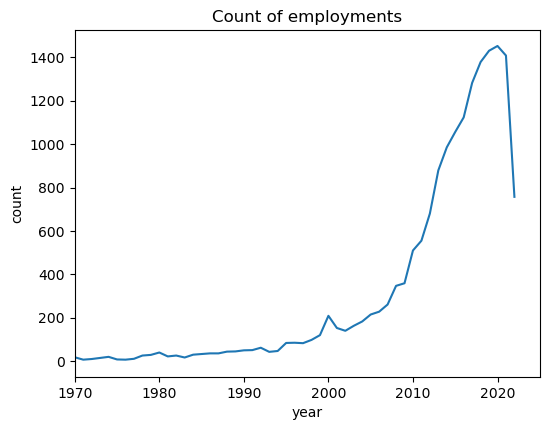

In [15]:
#df_sel = df_jobs_stats
#df_sel = df_jobs_stats[df_jobs_stats['area'] == 'Europe']
df_sel = df_jobs_stats[df_jobs_stats['country_code'] == 'ITA']

ser_dates = pd.to_datetime(df_sel['started_on'], errors = 'coerce')
ser_dates = ser_dates[~ser_dates.isna()]
ser_dates = ser_dates.dt.year

df_stats_dates = pd.DataFrame(ser_dates.groupby(ser_dates).count().rename('count'))
df_stats_dates.index.names = ['date']
df_stats_dates['cumulative count'] = df_stats_dates['count'].cumsum()

data_plot = df_stats_dates.iloc[:-1]

fig, ax = subplots(figsize = (6, 4.5))
ax.plot(data_plot.index, data_plot['count'])
ax.set_xlim(1970, 2025)
ax.set_xlabel('year')
ax.set_ylabel('count')
ax.set_title('Count of employments')
#savefig(path_images + 'count_employments.png', bbox_inches = 'tight')
show()

## Stats of companies

In [16]:
df_stats_companies = (
    df_jobs.groupby('org_uuid', as_index = False).value_counts(['job_type'])   # group by id of company and count the occurrences of each 'job_type' in separate rows
    .pivot_table(index = 'org_uuid', columns = 'job_type', values = 'count', aggfunc = 'sum', fill_value = 0)   # turn the different values of 'job_type' into separate columns
)

cols_fingerprint = df_stats_companies.columns.values.tolist()

df_stats_companies = df_organizations[['uuid', 'name', 'area', 'country_code', 'city']].merge(   # add info for each company
    df_stats_companies,
    how = 'inner',
    left_on = 'uuid',
    right_on = 'org_uuid'
).drop('uuid', axis = 1)

df_stats_companies['country_code'] = df_stats_companies['country_code'].apply(lambda x: x if type(x) == str else None)
df_stats_companies['city'] = df_stats_companies['city'].apply(lambda x: unidecode(x) if type(x) == str else None)

df_stats_companies

,name,area,country_code,city,advisor,board_member,board_observer,employee,executive
0,Wetpaint,USA,USA,New York,0,2,0,3,11
1,Zoho,USA,USA,Pleasanton,0,1,0,52,30
2,Digg,USA,USA,New York,0,4,0,34,34
3,Omidyar Network,USA,USA,Redwood City,3,1,0,53,94
4,Meta,USA,USA,Menlo Park,19,21,2,2047,935
...,...,...,...,...,...,...,...,...,...
995008,AiXGen,None,None,None,0,0,0,0,1
995009,Mokaos,None,None,None,0,0,0,0,1
995010,CRM Mentors,USA,USA,Chicago,0,0,0,0,1
995011,The Bagel Authority,USA,USA,Spokane,0,0,0,0,1


In [17]:
df_stats_companies.shape[0]

995013

In [18]:
df_stats_companies[df_stats_companies['area'] == 'USA'].shape[0]

474268

In [19]:
df_stats_companies[df_stats_companies['area'] == 'Europe'].shape[0]

230508

In [20]:
df_stats_companies[df_stats_companies['country_code'] == 'ITA'].shape[0]

12063

In [21]:
df_stats_companies[(df_stats_companies['country_code'] == 'ITA') & (df_stats_companies['city'].isin(['Milano', 'Milan']))].shape[0]

2866

In [22]:
df_stats_companies[(df_stats_companies['country_code'] == 'ITA') & (df_stats_companies['city'].isin(['Roma', 'Rome']))].shape[0]

1275

In [23]:
df_stats_companies[(df_stats_companies['country_code'] == 'ITA') & (df_stats_companies['city'].isin(['Catania']))].shape[0]

71

## Stats of cites

In [24]:
n_min_of_companies = 100

cols_num = df_stats_companies.select_dtypes(include = 'number').columns.tolist()

df_stats_cities = (
    df_stats_companies
    .groupby(['city', 'country_code', 'area'])
    .agg({'name': 'count'} | {c: 'sum' for c in cols_num})
    .rename(columns = {'name': 'companies'})
)

df_stats_cities = df_stats_cities[df_stats_cities['companies'] > n_min_of_companies].reset_index()
df_stats_cities

,city,country_code,area,companies,advisor,board_member,board_observer,employee,executive
0,'s-hertogenbosch,NLD,Europe,114,2,7,0,32,143
1,Aachen,DEU,Europe,164,8,32,2,91,306
2,Aalborg,DNK,Europe,118,2,30,1,56,187
3,Aarhus,DNK,Europe,319,15,49,3,157,536
4,Aberdeen,GBR,Europe,287,10,41,0,124,437
...,...,...,...,...,...,...,...,...,...
895,Youngstown,USA,USA,110,0,8,0,20,166
896,Zagreb,HRV,Europe,359,27,38,0,139,505
897,Zaragoza,ESP,Europe,142,3,8,0,57,186
898,Zug,CHE,Europe,641,115,196,6,384,1395


In [25]:
df_stats_cities[df_stats_cities['city'] == 'Rome']

,city,country_code,area,companies,advisor,board_member,board_observer,employee,executive
689,Rome,ITA,Europe,807,48,139,5,461,1297


In [26]:
df_stats_cities[df_stats_cities['city'] == 'Rome']

,city,country_code,area,companies,advisor,board_member,board_observer,employee,executive
689,Rome,ITA,Europe,807,48,139,5,461,1297


In [28]:
df_stats_cities[df_stats_cities['city'] == 'Catania']

,city,country_code,area,companies,advisor,board_member,board_observer,employee,executive


In [29]:
df_stats_cities.groupby('area').agg({'city': 'count', 'companies': 'sum'}).rename(columns = {'city': 'cities'})

,cities,companies
area,,
Europe,256,151358
USA,644,377168


In [129]:
#pd.isnull(df_stats_cities['city']).values.sum()
#pd.isnull(df_stats_cities['country_code']).values.sum()

### Clustering

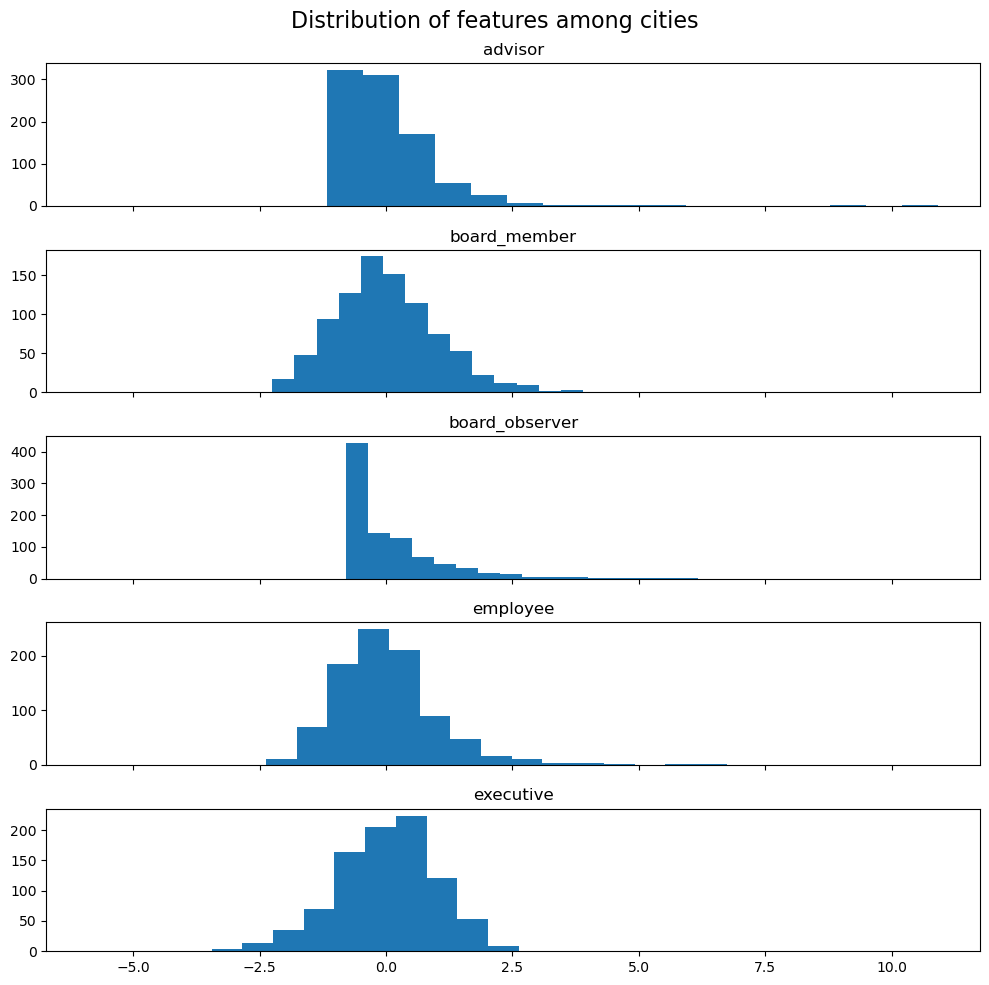

In [30]:
features = df_stats_cities[cols_fingerprint].div(df_stats_cities[cols_fingerprint].sum(axis = 1), axis = 0)

preprocess = Pipeline([
    ('scaler', StandardScaler()), # Scaling the data so that all the features become comparable
    #('normalizer', Normalizer()) # Normalizing the data so that each sample has unit norm
])

#features_processed = features.copy()
features_processed = pd.DataFrame(preprocess.fit_transform(features), columns = features.columns)

fig, axs = subplots(nrows = 5, ncols = 1, figsize = (10, 10), sharex = True, tight_layout = True)
for i in range(features_processed.shape[1]):
    ax = axs[i]
    ax.hist(features_processed.iloc[:, i], bins = 'doane')
    ax.set_title(features_processed.columns[i])
fig.suptitle('Distribution of features among cities', size = 16)
savefig('preprocessed features.png', bbox_inches = 'tight')
show()

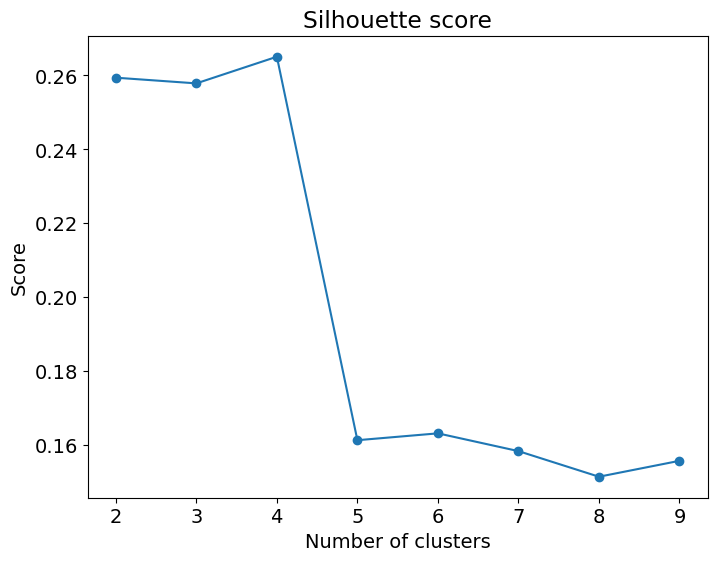

In [31]:
metric = 'euclidean'; linkage = 'ward'
#metric = 'euclidean'; linkage = 'average'
#metric = 'cosine'; linkage = 'average'

list_k = []
list_scores = []

for k in range(2, 10):
    labels = AgglomerativeClustering(n_clusters = k, metric = metric, linkage = linkage).fit_predict(features_processed)
    list_k.append(k)
    list_scores.append(silhouette_score(X = features_processed, labels = labels, metric = metric))

###

rcParams['font.size'] = 14

fig, ax = subplots(figsize = (8, 6))
ax.plot(list_k, list_scores)
ax.scatter(list_k, list_scores)
#ax.set_xlim(0, 10)
#ax.set_ylim(-1, 1)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Score')
ax.set_title('Silhouette score')
savefig('score.png', bbox_inches = 'tight')
show()

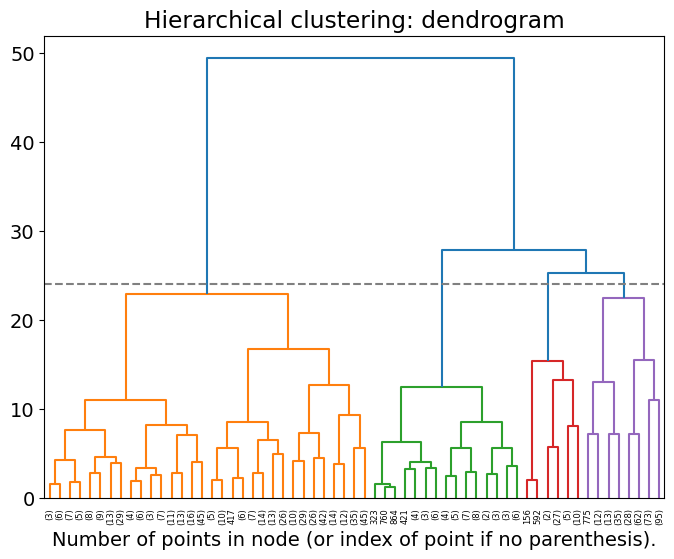

In [32]:
n_clusters = 4

model = AgglomerativeClustering(n_clusters = n_clusters, metric = metric, linkage = linkage, compute_distances = True)
model = model.fit(features_processed)

threshold_separation = 24

fig, ax = subplots(figsize = (8, 6))
plot_dendrogram(model, p = 5, truncate_mode = 'level', color_threshold = threshold_separation)
ax.axhline(y = threshold_separation, color = 'grey', linestyle = '--')
ax.set_xlabel('Number of points in node (or index of point if no parenthesis).')
ax.set_title('Hierarchical clustering: dendrogram')
savefig('dendrogram.png', bbox_inches = 'tight')
show()

In [33]:
#values = 1   # per contare il numero di città in USA/Europe
values = df_stats_cities['companies']   # per contare il numero di compagnie in USA/Europe

stats_clusters = df_stats_cities.assign(
    Europe = values * (df_stats_cities['area'] == 'Europe'),
    USA = values * (df_stats_cities['area'] == 'USA')
).assign(cluster = model.labels_, cities = 1).groupby('cluster')[['cities', 'companies'] + cols_area + cols_fingerprint].sum()

for cols in [cols_area, cols_fingerprint]:
    stats_clusters[cols] = stats_clusters[cols].div(stats_clusters[cols].sum(axis = 1), axis = 0)

stats_clusters.sort_values(by = cols_area[0], axis = 0, ascending = False, inplace = True)   # sort by fraction of first area
stats_clusters.index = pd.Index(list(range(n_clusters)), name = 'cluster')   # reset index

stats_clusters

,cities,companies,Europe,USA,advisor,board_member,board_observer,employee,executive
cluster,,,,,,,,,
0,319,312396,0.347645,0.652355,0.033283,0.084309,0.003460,0.264402,0.614547
1,480,140998,0.275493,0.724507,0.019429,0.064233,0.002099,0.172981,0.741258
2,55,19267,0.120880,0.879120,0.034476,0.121383,0.009475,0.217947,0.616719
3,46,55865,0.028318,0.971682,0.066015,0.079788,0.005522,0.256675,0.592000


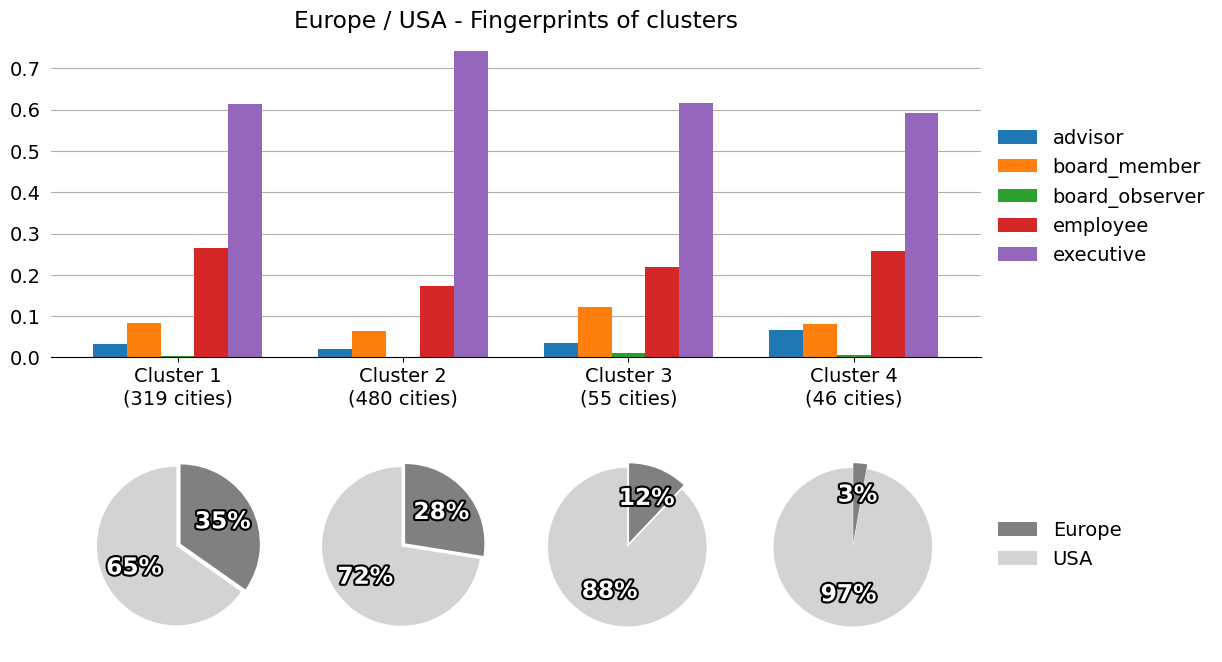

In [34]:
fig = figure(figsize = (12, 8))
gs = GridSpec(
    nrows = 2, ncols = n_clusters + 2, figure = fig,
    hspace = 0.3, height_ratios = [3, 2],
    width_ratios = [0.01] + [1] * n_clusters + [0.01]   # 2 extra columns to align pie charts with bar charts
)

ax_bar = fig.add_subplot(gs[0, :])
axs_pie = []
for i in range(n_clusters + 2):
    axs_pie.append(fig.add_subplot(gs[1, i]))

###

x_base = np.arange(n_clusters)
n_features = len(cols_fingerprint)
width = 0.75 / n_features
x_labels = x_base + width * (n_features - 1) / 2

labels = [
    'Cluster ' + str(i + 1)
    + '\n(' + str(stats_clusters.loc[i, 'cities']) + ' cities)'
#    + '\n(' + str(stats_clusters.loc[i, 'companies']) + ' companies)'
    for i in range(n_clusters)
]

for i in range(n_features):
    ax_bar.bar(x_base + i * width, stats_clusters[cols_fingerprint[i]], width = width, label = cols_fingerprint[i], zorder = 2)

ax_bar.spines[['left', 'right', 'top']].set_visible(False)
ax_bar.grid(axis = 'y')
for tick in ax_bar.yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
ax_bar.set_xticks(x_labels, labels)
ax_bar.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), frameon = False)
ax_bar.set_title(' / '.join(cols_area) + ' - Fingerprints of clusters')

###

for i in [0, -1]:
    axs_pie[i].axis('off')

for i in range(n_clusters):
    ax = axs_pie[i + 1]
    wedges, texts, autotexts = ax.pie(
        stats_clusters.loc[i, cols_area].values,
        explode = [0.03] * len(cols_area),
        colors = ['grey', 'lightgrey'],
        startangle = 90,
        counterclock = False,
        autopct = lambda x: f'{x:.0f}%',
        textprops = dict(
            color = 'white', size = 'large', weight = 'bold',
            path_effects = [withStroke(linewidth = 3, foreground = 'black')]
        )
    )
    #ax.set_title('Cluster ' + str(i + 1))
axs_pie[-1].legend(wedges, cols_area, loc = 'center left', bbox_to_anchor = (1, 0.5), frameon = False)

###

savefig('a.png', bbox_inches = 'tight')
show()